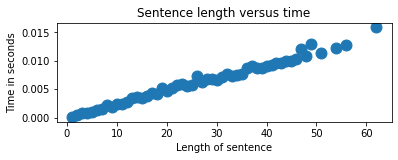

In [10]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
from nltk.corpus.reader import PlaintextCorpusReader
from nltk import bigrams
import operator
import datetime
import matplotlib.pyplot as plt


data = open("/home/eva/Downloads/eva/de-train.tt", "r")
words = []
tags = []
single_sent=[]
tags_pair = []
tags_coming_start=[]
count = 0
for line in data:
    if line != "\n":
        word, tag = line.split("\t")
        words.append(word.replace("\n", "").lower())
        tags.append(tag.replace("\n", ""))
        single_sent.append(tag.replace("\n", ""))
    else:
        count += 1
        tags_pair += bigrams(single_sent)
        tags_coming_start.append(single_sent[0])
        single_sent = []

unique_words = set(words)
unique_tags = set(tags)
words_tags = Counter(zip(words, tags))
tags_count = Counter(tags)
tags_pair_count=Counter(tags_pair)
count_start_tag = Counter(tags_coming_start)


def emission(word):
    """
    This function saves the emission probability, i.e., the probability of a word being
    generated from a tag
    """  
    return {x: words_tags.get((word,x),0)/tags_count.get(x) for x in unique_tags}
    
def transition(tag):
    """
    This function saves the transition probability, i.e., the probability of transiting
    from one POS tag to the next
    """
    return {x: tags_pair_count.get((x,tag),0)/tags_count.get(x) for x in unique_tags}


def hmm_training():
    """
    This function calculates the initial probability, i.e., the probability with which the 
    sentence will start with a certain word
    """
    emission_prob = {word: emission(word) for word in unique_words}
    transition_prob = {tag: transition(tag) for tag in unique_tags}
    initial_prob = {tag: count_start_tag.get(tag,0)/count for tag in unique_tags}
    return emission_prob, transition_prob, initial_prob
back_pointer = {}

def get_max_from_dict(x):
    """
    This function gets the keys with the maximum value in the dictionary
    """
    return max(x.items(), key=operator.itemgetter(1))[0]
    
def forward_viterbi(words, emission_prob, transition_prob, initial_prob):
    """
    This function calculates the forward probability of all the possible tags using HMM
    """
    ini_prob = initial_prob.copy()
    for i,word in enumerate(words):
        if word in emission_prob:
            emission_prob_each = emission_prob[word]
        else:
            emission_prob_each = {tag:1 for tag in unique_tags}
        result = transition_prob.copy()
        if i != 0:
            result = {tag:{ntag: emission_prob_each[tag]*prob for ntag, prob in next_tags.items()} for tag, next_tags in transition_prob.items()}
            result = {tag:{ntag:ini_prob[ntag]*prob for ntag, prob in next_tags.items()} for tag, next_tags in result.items()}
        else:
            result = emission_prob_each.copy()
            result = {each:value*ini_prob[each] for each, value in result.items()}
        
        back_pointer[word] = result.copy()
        if i!=0:
            ini_prob = {tag:next_tag[get_max_from_dict(next_tag)] for tag,next_tag in result.items()}
        else:
            ini_prob=result
    return back_pointer


def backward_viterbi(words,back_pointer):
    """
    This function uses backpointer to backtrack the most likely hidden path
    """
    results={}
    if len(words) >1:
        m = {each: get_max_from_dict(value) for each,value in back_pointer[words[-1]].items()}
        mm = get_max_from_dict({each:back_pointer[words[-1]][each][value]  for each,value in m.items()})
        m = m[mm]
    else:
        mm = get_max_from_dict(back_pointer[words[-1]])

    words = words[::-1]
    for i, word in enumerate(words[1:]):
        if i < len(words)-2:
            results[word] = m
            m = back_pointer[word][m]
            m = get_max_from_dict(m)
        else:
            results[word] = m

    results[words[0]] = mm
    return results


def evaluation_func(eval_path):
    """
    This function evaluates the POS tagger
    """
    f  = open(eval_path, "r")
    r = open("dd-test.t", "w")
    single_sent = []
    count = 0
    length_time = {}
    emission_prob, transition_prob, initial_prob= hmm_training()
    for line in f:
        if line != "\n":
            single_sent.append(line.replace("\n", ""))
        else:
            a  = datetime.datetime.now()
            back_pointer = forward_viterbi(single_sent, emission_prob, transition_prob, initial_prob)
            results = backward_viterbi(single_sent,back_pointer)
            length_time[len(single_sent)] = (datetime.datetime.now()-a).total_seconds()
            for each_word in single_sent:
                r.write(each_word + "\t" + results[each_word])
                r.write("\n")
            r.write("\n")
            single_sent = []
            del results
    return length_time

length_time = evaluation_func("/home/eva/Downloads/eva/de-test.t")
plt.figure()
plt.subplot(211)
plt.scatter(list(length_time.keys()),list(length_time.values()), s=120)
plt.ylabel('Time in seconds')
plt.xlabel('Length of sentence')
plt.title("Sentence length versus time")
plt.show()

! [evaluation matrix](/home/eva/Downloads/eva/eval-l-t.png)

In [ ]:
! [evaluation matrix](/home/eva/Downloads/eva/accuracy_score.png)